## Visão geral
Neste notebook usaremos várias técnicas e métodos para um problema de classificação de texto, que compreende a análise de sentimentos em uma base de dados financeiros.


### O que é análise de sentimento?
A Análise de Sentimento é uma tarefa de PLN usada para interpretar as emoções, comentários e avaliações (positivas, negativas ou neutras) por trás dos dados do texto.

### Aplicações de análise de sentimento:
* Análise de mídia social;
* Sentimento público sobre produtos;
* Moderação de conteúdo;
* Análise do mercado de ações;

### Bibliotecas

In [1]:
# nltk imports
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # bags of words e TF-IDF
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import train_test_split  
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn import pipeline

import plotly.graph_objects as go

from gensim.models import KeyedVectors
import re

In [2]:
import numpy as np
import pandas as pd

# Carregamento do banco
# df = pd.read_csv('/kaggle/input/sentiment-analysis/sentiment_analysis.csv')
df = pd.read_csv('data/sentiment_analysis_pt_br.csv')

df.head()

,Sentence,Sentiment
0,A tecnologia GeoSolutions aproveitará as soluç...,positive
1,"$ Esi em baixos, queda de US $ 1,50 a US $ 2,5...",negative
2,"No último trimestre de 2010, as vendas líquida...",positive
3,De acordo com a Câmara de Comércio Finlandesa-...,neutral
4,A empresa de compra sueca vendeu sua participa...,neutral


In [3]:
df.shape

(5842, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [5]:
# Vamos visulizar as classes do problema
unique_sentiments = df.Sentiment.unique()
unique_sentiments

array(['positive', 'negative', 'neutral'], dtype=object)

<Axes: xlabel='Sentiment'>

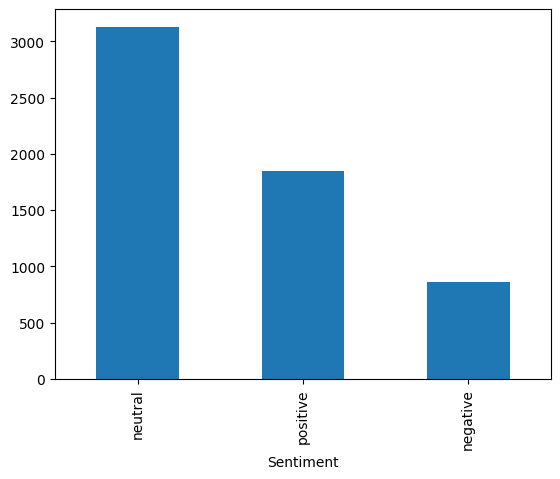

In [6]:
df.Sentiment.value_counts().plot.bar()

De forma mais elegante...

In [7]:
sentiment_counts = df['Sentiment'].value_counts().sort_index()

sentiment_labels = ['Negativo', 'Neutro', 'Positivo']
sentiment_colors = ['red', 'orange', 'blue']

fig = go.Figure(data=[go.Pie(labels=sentiment_labels,#sentiment_counts.index, 
                             values=sentiment_counts.values,
                             textinfo='percent+value+label',
                             marker_colors=sentiment_colors,
                             textposition='auto',
                             hole=.3)])

fig.update_layout(
    title_text='Distribuição Percentual',
    template='plotly_white',
    xaxis=dict(
        title='Sources',
    ),
    yaxis=dict(
        title='Total',
    )
)

fig.update_traces(marker_line_color='black', 
                  marker_line_width=1.5, 
                  opacity=0.8)
 
fig.show()

In [8]:
# Convertendo as classes em "categorias"

dicto = {'positive': 1, 'neutral': 0 , 'negative': -1}

df.Sentiment = df.Sentiment.map(dicto)

In [9]:
def classical_model(df, bow=False, TFIDF=False, Ngram=False,
                    model=linear_model.LogisticRegression(solver='liblinear')):
    '''
    Automatiza modelos de ML clássicos para treinar e avaliar na base de dados

    Args:
    df : pandas DataFrame
        Base de dados em DataFrame
    bow : bool
        Flag para usar bag of words (binary, count, or frequency)
    TFIDF : bool
        Flag para usar Tfidf 
    Ngram : tuple
        Shape do intervalo em Ngram ((1,2) para bigrams)
    model : scikit-learn estimator
        Modelo de ML para treinamento e inferência

    Returns:
    None
    '''

    if bow:
        count_vec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)
    elif TFIDF:
        count_vec = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
    elif Ngram:
        count_vec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None, ngram_range=Ngram)

    x_train, x_test, y_train, y_test = train_test_split(df.Sentence, df.Sentiment, test_size=0.2,
                                                 random_state=42, stratify=df.Sentiment, shuffle=True)
    x_train.reset_index(inplace=True, drop=True)
    x_test.reset_index(inplace=True, drop=True)
    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    
    # Vamos utilizar o método de validação cruzada estratificada para avaliar as métricas de teste
    # Importante pois nossa base é altamente desbalanceada
    np.random.seed(42)
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits)

    mean_precision = 0
    mean_recall = 0
    for train, val in kf.split(X=x_train, y=y_train):
    
        xtrain = x_train[train]
        xval = x_train[val]
        ytrain = y_train[train]
        yval = y_train[val]

        count_vec.fit(xtrain)
        xtrain = count_vec.transform(xtrain)
        xval = count_vec.transform(xval)

        model.fit(xtrain, ytrain)
        preds = model.predict(xval)
        precision = precision_score(yval, preds, average='macro')
        recall = recall_score(yval, preds, average='macro')
        mean_precision+=precision
        mean_recall+=recall
        print('precision score:', precision)
        print('recall score:', recall)
        print("========================================================")
    
    mean_precision/=n_splits
    mean_recall/=n_splits
    print("Média sobre os",n_splits,"folds:")
    print("Precisão:", mean_precision, "Revocação:", mean_recall)

    if bow:
        count_vec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)
    elif TFIDF:
        count_vec = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
    elif Ngram:
        count_vec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None, ngram_range=Ngram)

    count_vec.fit(x_train)
    x_train = count_vec.transform(x_train)
    x_test = count_vec.transform(x_test)

    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    print(classification_report(y_test, preds))

## Abordagem 1:
### Regressão Logística + BOW

In [10]:
# Modelo de linha de base.
# Vamos começar com um modelo de regressão logística, pois é o mais rápido para dados esparsos de alta dimensão!

classical_model(df, bow=True, model=linear_model.LogisticRegression(solver='liblinear'))

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\joaov/nltk_data'
    - 'c:\\Users\\joaov\\AppData\\Local\\Programs\\Python\\Python312\\nltk_data'
    - 'c:\\Users\\joaov\\AppData\\Local\\Programs\\Python\\Python312\\share\\nltk_data'
    - 'c:\\Users\\joaov\\AppData\\Local\\Programs\\Python\\Python312\\lib\\nltk_data'
    - 'C:\\Users\\joaov\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


Podemos ver que os rótulos **1 e 0 têm pontuação superior a 70 por cento**, mas a pontuação do rótulo **-1 é muito baixa**, portanto, podemos concluir que precisamos continuar modelando até que essas pontuações melhorem.

## Abordagem 2: 

### Naive Bayes + BOW

In [ ]:
classical_model(df, bow=True, model=MultinomialNB()) # multiclassification

É evidente que para a **classe -1 os valores das métricas melhoraram um pouco**, então este modelo será o novo modelo de linha de base para este problema.

## Abordagem 3: 

### Naive Bayes com TF-IDF

In [ ]:
classical_model(df, model=MultinomialNB(), TFIDF=True)

Infelizmente a **pontuação de revocação para o rótulo -1 está insatisfatória**

## Abordagem 4: 

### Naive Bayes com N-grams

In [ ]:
classical_model(df, model=MultinomialNB(), Ngram=(1,2))
# sugestão, avaliem com outras formações n-gram

A abordagem N-gram **não surtiu efeito expressivamente positivo no valor das métricas**. Portanto, é evidente que o modelo de linha de base (NB + BoW) ainda é o melhor até agora.

## Pre-processamento de texto

**Remover todas as palavras "irrelevantes"** pode alterar o contexto da frase, fique atento(a).

Por exemplo, **"Ele não é uma boa pessoa"** será alterado para **" 'Ele' , 'boa', 'pessoa'"** que é o completo oposto da frase.

Vale ressaltar que não é porque estamos removendo palavras "irrelevantes" que os resultados dos modelos irão melhorar.

In [ ]:
# Agora vamos fazer uma limpeza nos dados de texto e aplicá-los ao modelo de linha de base e comparar as precisões.
# NÃO FUNCIONOU
# Erro na instalação do wordnet, mesmo após várias tentativas

# def process_text(text):
#     
#     text = word_tokenize(text) # tokeniza o texto
#     text = [re.sub('[^A-Za-z]+', '', word) for word in text] # esta linha substitui qualquer espaço em branco antes da palavra removendo o espaço
#     text = [word.lower() for word in text if word.isalpha()] # minuscula
#     text = [word for word in text if word not in stop_words]
#     text = [WordNetLemmatizer().lemmatize(word) for word in text] # lematização de palavras, então quando vemos "pessoas" e "pessoa", ambas são tratadas como uma palavra "pessoa"
#     text = ' '.join(text) # concatenação
#     return text

In [ ]:
stop_words = [i for i in stopwords.words('english') if "n't" not in i and i not in ('not','no')]
print(stop_words)

In [ ]:
text = 'He is not a good person'
token_text = word_tokenize(text)
[ word for word in token_text if word not in stop_words]

In [ ]:
# NÃO FUNCIONOU
# df.Sentence = df.Sentence.apply(process_text) # esta linha aplica a função process_text à "Sentença" no conjunto de dados
# df.Sentence

## Abordagem 5:

### Texto processado + BoW + Naive Bayes

In [ ]:
classical_model(df, model=MultinomialNB(), bow=True)

Após alguma limpeza de texto, esta abordagem supera o modelo base em alguns casos, mas perde em outros, ficando praticamente no mesmo patamar. **Superamos nosso modelo de linha de base por uma pequena margem em revocação**, o que esperávamos. Iremos utilizar o modelo acima como nosso novo modelo de linha de base.

Agora vamos entrar nos modelos com **embedding de palavras**

Nos modelos acima, cada token de palavra é convertido em tokens inteiros por (BoW e TF-IDF). Agora vamos converter esses **tokens inteiros em vetores.**

## Abordagem 6:

### Vetor FastText + Naive Bayes Baseline 

In [ ]:
# Neste modelo usaremos vetores FastText, e também converteremos cada vetor de palavras em vetores de frases.
# O código foi retirado de https://fasttext.cc/docs/en/english-vectors.html, este código divide cada vetor por
# espaço e nova linha, para mais informações acesse o link acima.

def sentence_to_vec(sentence, embedding_dict, tokenizer):
    # Esta função converte uma frase em um vetor de vetores de palavras
    words = tokenizer(sentence)
    embedding_list = []
    for word in words:
        if word in embedding_dict:
            embedding_list.append(embedding_dict[word])
    if len(embedding_list) == 0:
        # se nenhum vetor for encontrado, retorna zeros
        return np.zeros(300)
    embedding_list = np.array(embedding_list)
    vector = embedding_list.sum(axis=0) / len(embedding_list)
    return vector

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.Sentence, df.Sentiment, test_size=0.2,
                                                 random_state=42, stratify=df.Sentiment, shuffle=True)
x_train.reset_index(inplace=True, drop=True)
x_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [ ]:
# NÃO FUNCIONOU
# [Errno 2] No such file or directory: './fasttext_embedding/crawl-300d-2M.vec'

# Inicia a classe kfold do módulo model_selection
# n_splits = 5
# kf = StratifiedKFold(n_splits=n_splits)

# mean_precision = 0
# mean_recall = 0

# Carrega os embeddings na memória
# print("Loading embeddings")
#if embeddings==None:
# embeddings = KeyedVectors.load_word2vec_format('./fasttext_embedding/crawl-300d-2M.vec')

# Crie embeddings de frases
# print("Creating sentence vectors")
# vectors = []
# for sentence in x_train.values:
#     vectors.append(sentence_to_vec(sentence=sentence, embedding_dict=embeddings, tokenizer=word_tokenize))
# vectors = np.array(vectors)

# for fold_, (train_, valid_) in enumerate(kf.split(X=x_train, y=y_train)):
#     print("Fold: ", fold_)
#     xtrain = vectors[train_, :]
#     ytrain = y_train[train_]
#     xtest = vectors[valid_, :]
#     ytest = y_train[valid_]

#     scaler = MinMaxScaler()
#     x_train_scaled = scaler.fit_transform(xtrain)
#     x_test_scaled = scaler.transform(xtest)
    
#     model = MultinomialNB()
#     model.fit(x_train_scaled, ytrain)
    
#     y_pred = model.predict(x_test_scaled)
#     pres_score = precision_score(ytest, y_pred, average='macro')
#     rec_score = recall_score(ytest, y_pred, average='macro')
#     print('Precision and recall scores:', pres_score, rec_score)
#     print("======================================================")

#print(classification_report(y_test, y_pred, labels=[1, -1, 0]))

**Incrível...É o nosso modelo com pior desempenho até agora!**

Continuaremos tentando com outros modelos e métodos.

## Abordagem 7: 

### BoW + SVM

In [ ]:
# Vamos avaliar a SVM com BoW
classical_model(df, model=SVC(C=10), bow=True)

Novamente, os resultados estão bem ruins...hipóteses?

## Abordagem 8: 

### BoW + RF

In [ ]:
# Vamos avaliar a Random Forest com BoW
classical_model(df, model=RandomForestClassifier(n_estimators=70, ccp_alpha=0.001, random_state=42), bow=True)
# Estes hiper-parâmetros foram ajustados "na mão"

O modelo RF está se saindo bem, porém ainda está com dificuldade em melhorar a revocação da classe -1...

### Discussão:

#### O que você imagina estar influenciando na dificuldade dos modelos em atingir bons resultados, além do desbalanceamento das classes?

#### Levante hipóteses a partir da teoria abordada, da sua observação e da experiência...

#### Problemas:
- O corpus é muito pequeno pelo que ele se proprõe a rotular: a precisão dificilmente será 100%, data a complexidade e unicidade de algumas das amostras;
- Existem muitas amostras da categoria 'neutro', o que torna o modelo tendencioso e agrava o primeiro problema para as categorias 'negativo' e 'positivo';
- Várias amostras do corpus possuem links ao final, isso pode estar prejudicando muito o aprendizado e a classificação por parte do modelo;
- Quase todas as amostras possuem substantivos , nomes e valores, irrelevantes para o objetivo do modelo;
- O nível de formalidade varia muito de uma amostra para outra, seria necessária uma amostra muito maior ou uma aproximação apropriada para lidar com esta variação;
- Algumas amostras fazem sentido como uma manchete de uma notícia, outras não possuem sentido por si só e não deveriam ser classificadas, pois podem entrar para o conjunto 'neutro' devido a falta de contexto;

#### Possível solução para o aumento da precisão:
- Remover amostras muito longas e fora de contexto, sobretudo classificadas como 'neutro';
- Remover/tratar amostras com links, valores, nomes e substantivos, pois o modelo deveria lidar somente com a parte relevante das amostras.
- Enriquecer o corpus com mais amostras, e em seguida realizar nestas novas amostras as duas etapas acima;
- Testar novamente e realizar uma nova análise;

----------------

### DESAFIO:

Replicar a atividade desta aula prática traduzindo-a para a língua portuguesa.

Você deve utilizar o mesmo banco de dados, os mesmos modelos, e a mesma estrutura de treinamento e avaliação.

Sua tarefa será buscar, integrar, e aplicar soluções rápidas para resolver o problema de tradução do banco de dados, visto que atualmente é um problema fácil de ser resolvido. 

Obs.: Note que não estamos abordando o problema de desempenho dos modelos

Documente (em markdown mesmo) as considerações que fizer, as buscas, e decisões para a resolução do problema de análise de sentimento traduzido.

Esta é uma aplicação didática, para fins de desenvolvimento técnico de soluções práticas do dia a dia.

### Resolução do desafio:

#### ChatGPT + googletrans
- Realizei algumas consultas no ChatGPT para verificar como uma planilha .csv pode ser traduzida para o português. Ele me sugeriu o uso da biblioteca google-trans.
- Tive vários problemas com o uso desta biblioteca, pois ficava muito tempo rodando (de uma hora a uma hora e meia) e no final retornava erros dizendo que o formato que estava tentando traduzir era um NoneType, não uma string;
- Depois de várias execuções perdidas, resolvi colocar um try..except para pular as traduções com erro, que acreditava ser uma minoria, depois de ver o resultado, descobri que a biblioteca simplismente parava de traduzir a partir de um ponto aleatório do dataset;
- Inicialmente, acreditava que este ponto aleatório era sempre uma linha irregular que quebrava o tradutor, o que não se sustentou após a remoção de algumas destas linhas da planilha;
- Após verificar isso, parti para a tradução fracionada dos resultados de 1000 em 1000, tendo sucesso apenas na tradução das 2000 primeiras linhas;
- Acredito que a causa do problema esteja relacionada a políticas do próprio Google Tradutor;

#### ChatGPT, DeepL Translate
- Pedi para que o ChatGPT e o DeepL Translate traduzissem este dataset, mas o primeiro não conseguiu importar a biblioteca googletrans dentro do seu código, e o segundo não permite a tradução de um texto maior do que 1500 acaracteres;

#### ChatGPT + googletrans
- Após novas consultas, o ChatGPT me mostrou uma abordagem com o uso da biblioteca deep_translator. Infelizmente, ela ficou um bom tempo rodando e tudo indicava que o resultado seria similiar ao do googletrans;
- Resolvi adotar a mesma técnica de fracionamento, tendo sucesso ao traduzir as mais de 3000 frases restantes em planihlas separadas;
- Finalmente, as planilhas foram unificadas e salvas em um dataset online, sem erros de junção ou tradução verificados;

In [ ]:
!pip install googletrans==4.0.0-rc1

In [ ]:
import pandas as pd
from googletrans import Translator

def texto_para_portugues_google_trans(text):
    translator = Translator()
    
    try:
        translation = translator.translate(text, src='en', dest='pt')
        return translation.text
    except:
        return text

df = pd.read_csv('/kaggle/input/sentiment-analysis/sentiment_analysis.csv')
# df = df.head(1000)
# df = df.iloc[1000:2000]
df = df.iloc[2000:3000]

df['Sentence'] = df['Sentence'].apply(texto_para_portugues_google_trans)

# Salvar o DataFrame traduzido em um novo arquivo CSV
# df.to_csv('/kaggle/working/sentiment_analysis_pt_br_parte_1.csv', index=False)
# df.to_csv('/kaggle/working/sentiment_analysis_pt_br_parte_2.csv', index=False)
df.to_csv('/kaggle/working/sentiment_analysis_pt_br_parte_3.csv', index=False)

print('CSV traduzido salvo com sucesso.')

In [ ]:
!pip install deep-translator

In [ ]:
import pandas as pd
from deep_translator import GoogleTranslator

def texto_para_portugues_deep(text):
    translator = GoogleTranslator(source='en', target='pt')
    return translator.translate(text)

df = pd.read_csv('/kaggle/input/sentiment-analysis/sentiment_analysis.csv')
df = df.iloc[5000:5842]
df['Sentence'] = df['Sentence'].apply(texto_para_portugues_deep)

# Salvar o DataFrame traduzido em um novo arquivo CSV
df.to_csv('/kaggle/working/sentiment_analysis_pt_br_deep_tr_5000_5842.csv', index=False)

print('CSV traduzido salvo com sucesso.')

In [ ]:
import pandas as pd

paths = [
    '/kaggle/working/sentiment_analysis_pt_br_parte_1.csv',
    '/kaggle/working/sentiment_analysis_pt_br_parte_2.csv',
    '/kaggle/working/sentiment_analysis_pt_br_deep_tr_2000_3000.csv',
    '/kaggle/working/sentiment_analysis_pt_br_deep_tr_3000_4000.csv',
    '/kaggle/working/sentiment_analysis_pt_br_deep_tr_4000_5000.csv',
    '/kaggle/working/sentiment_analysis_pt_br_deep_tr_5000_5842.csv'
]

dfs = []
for path in paths:
    df = pd.read_csv(path)
    dfs.append(df)

cmb_df = pd.concat(dfs, ignore_index=True)
cmb_df.to_csv('/kaggle/working/sentiment_analysis_pt_br.csv', index=False)

####

#### Referências
- https://www.hashtagtreinamentos.com/tradutor-de-texto-em-python;
- https://github.com/ssut/py-googletrans;
- https://pypi.org/project/deep-translator/;